In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

sys.path.append('../src')
from models import VanillaAutoEncoder, VariationalAutoEncoder

import umap
import umap.plot
import hdbscan
import sklearn.datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


from sklearn.model_selection import train_test_split

/Applications/anaconda3/envs/maldi_autoencoder/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualise latent space

In [2]:
input_shape = 18000
latent_shape = 16

m_state_dict = torch.load('../experiments/results/latent_learning/pae_variational_epoch_20.pt', map_location=torch.device('cpu'))
model_new = VariationalAutoEncoder(input_shape, latent_shape)

model_new.load_state_dict(m_state_dict)

<All keys matched successfully>

In [3]:
# Loading DRIAMS and Alfred data

pae_driams = pd.read_csv('/Volumes/T7/MALDI_TOF/DRIAMS/pae_driams.csv')
pae_alfred_whole = pd.read_csv('/Volumes/T7/MALDI_TOF/DRIAMS/pae_alfred.csv')

alfred_train_ids = pd.read_csv("/Users/Andy/Dropbox/git_repos/Alfred_data/MALDI-TOF/alfred_train_ids.txt", header=None).values.flatten()

alfred_test_ids = pd.read_csv("/Users/Andy/Dropbox/git_repos/Alfred_data/MALDI-TOF/alfred_test_ids.txt", header=None).values.flatten()

pae_alfred = pae_alfred_whole.copy()[pae_alfred_whole['id'].isin(alfred_train_ids)]
pae_alfred_test = pae_alfred_whole.copy()[pae_alfred_whole['id'].isin(alfred_test_ids)]

alfred_antimicrobials = list(pae_alfred.columns[18001:].values)

In [4]:
antimicrobials = {"meropenem": "Meropenem", 
                  "amikacin": "Amikacin", 
                  "aztreonam": "Aztreonam", 
                  "ciprofloxacin": "Ciprofloxacin",
                  "piperacillin_tazobactam": "Piperacillin/tazobactam", 
                  "ceftolozane_tazobactam": "Ceftolozane/tazobactam",
                  "colistin": "Colistin", 
                  "tobramycin": "Tobramycin", 
                  "ceftazidime": "Ceftazidime",
                  "ceftazidime_avibactam": "Ceftazidime/avibactam", 
                  "imipenem": "Imipenem"}

In [5]:
max_intensity=0.009055 # Normalizing factor
X_cols = [str(2000 + i) for i in range(18000)]
alfred_X = torch.tensor(pae_alfred[X_cols].to_numpy() / max_intensity)
alfred_X_test = torch.tensor(pae_alfred_test[X_cols].to_numpy() / max_intensity)


In [6]:
with torch.no_grad():
    Z, mu, logvar = model_new.encoder(alfred_X.float())
    Z_test, _, _ = model_new.encoder(alfred_X_test.float())
mapper = umap.UMAP(n_neighbors=20, random_state=333).fit(Z)  # Initial seed=333

umap_values = mapper.transform(Z)
umap_alfred_test_values = mapper.transform(Z_test)

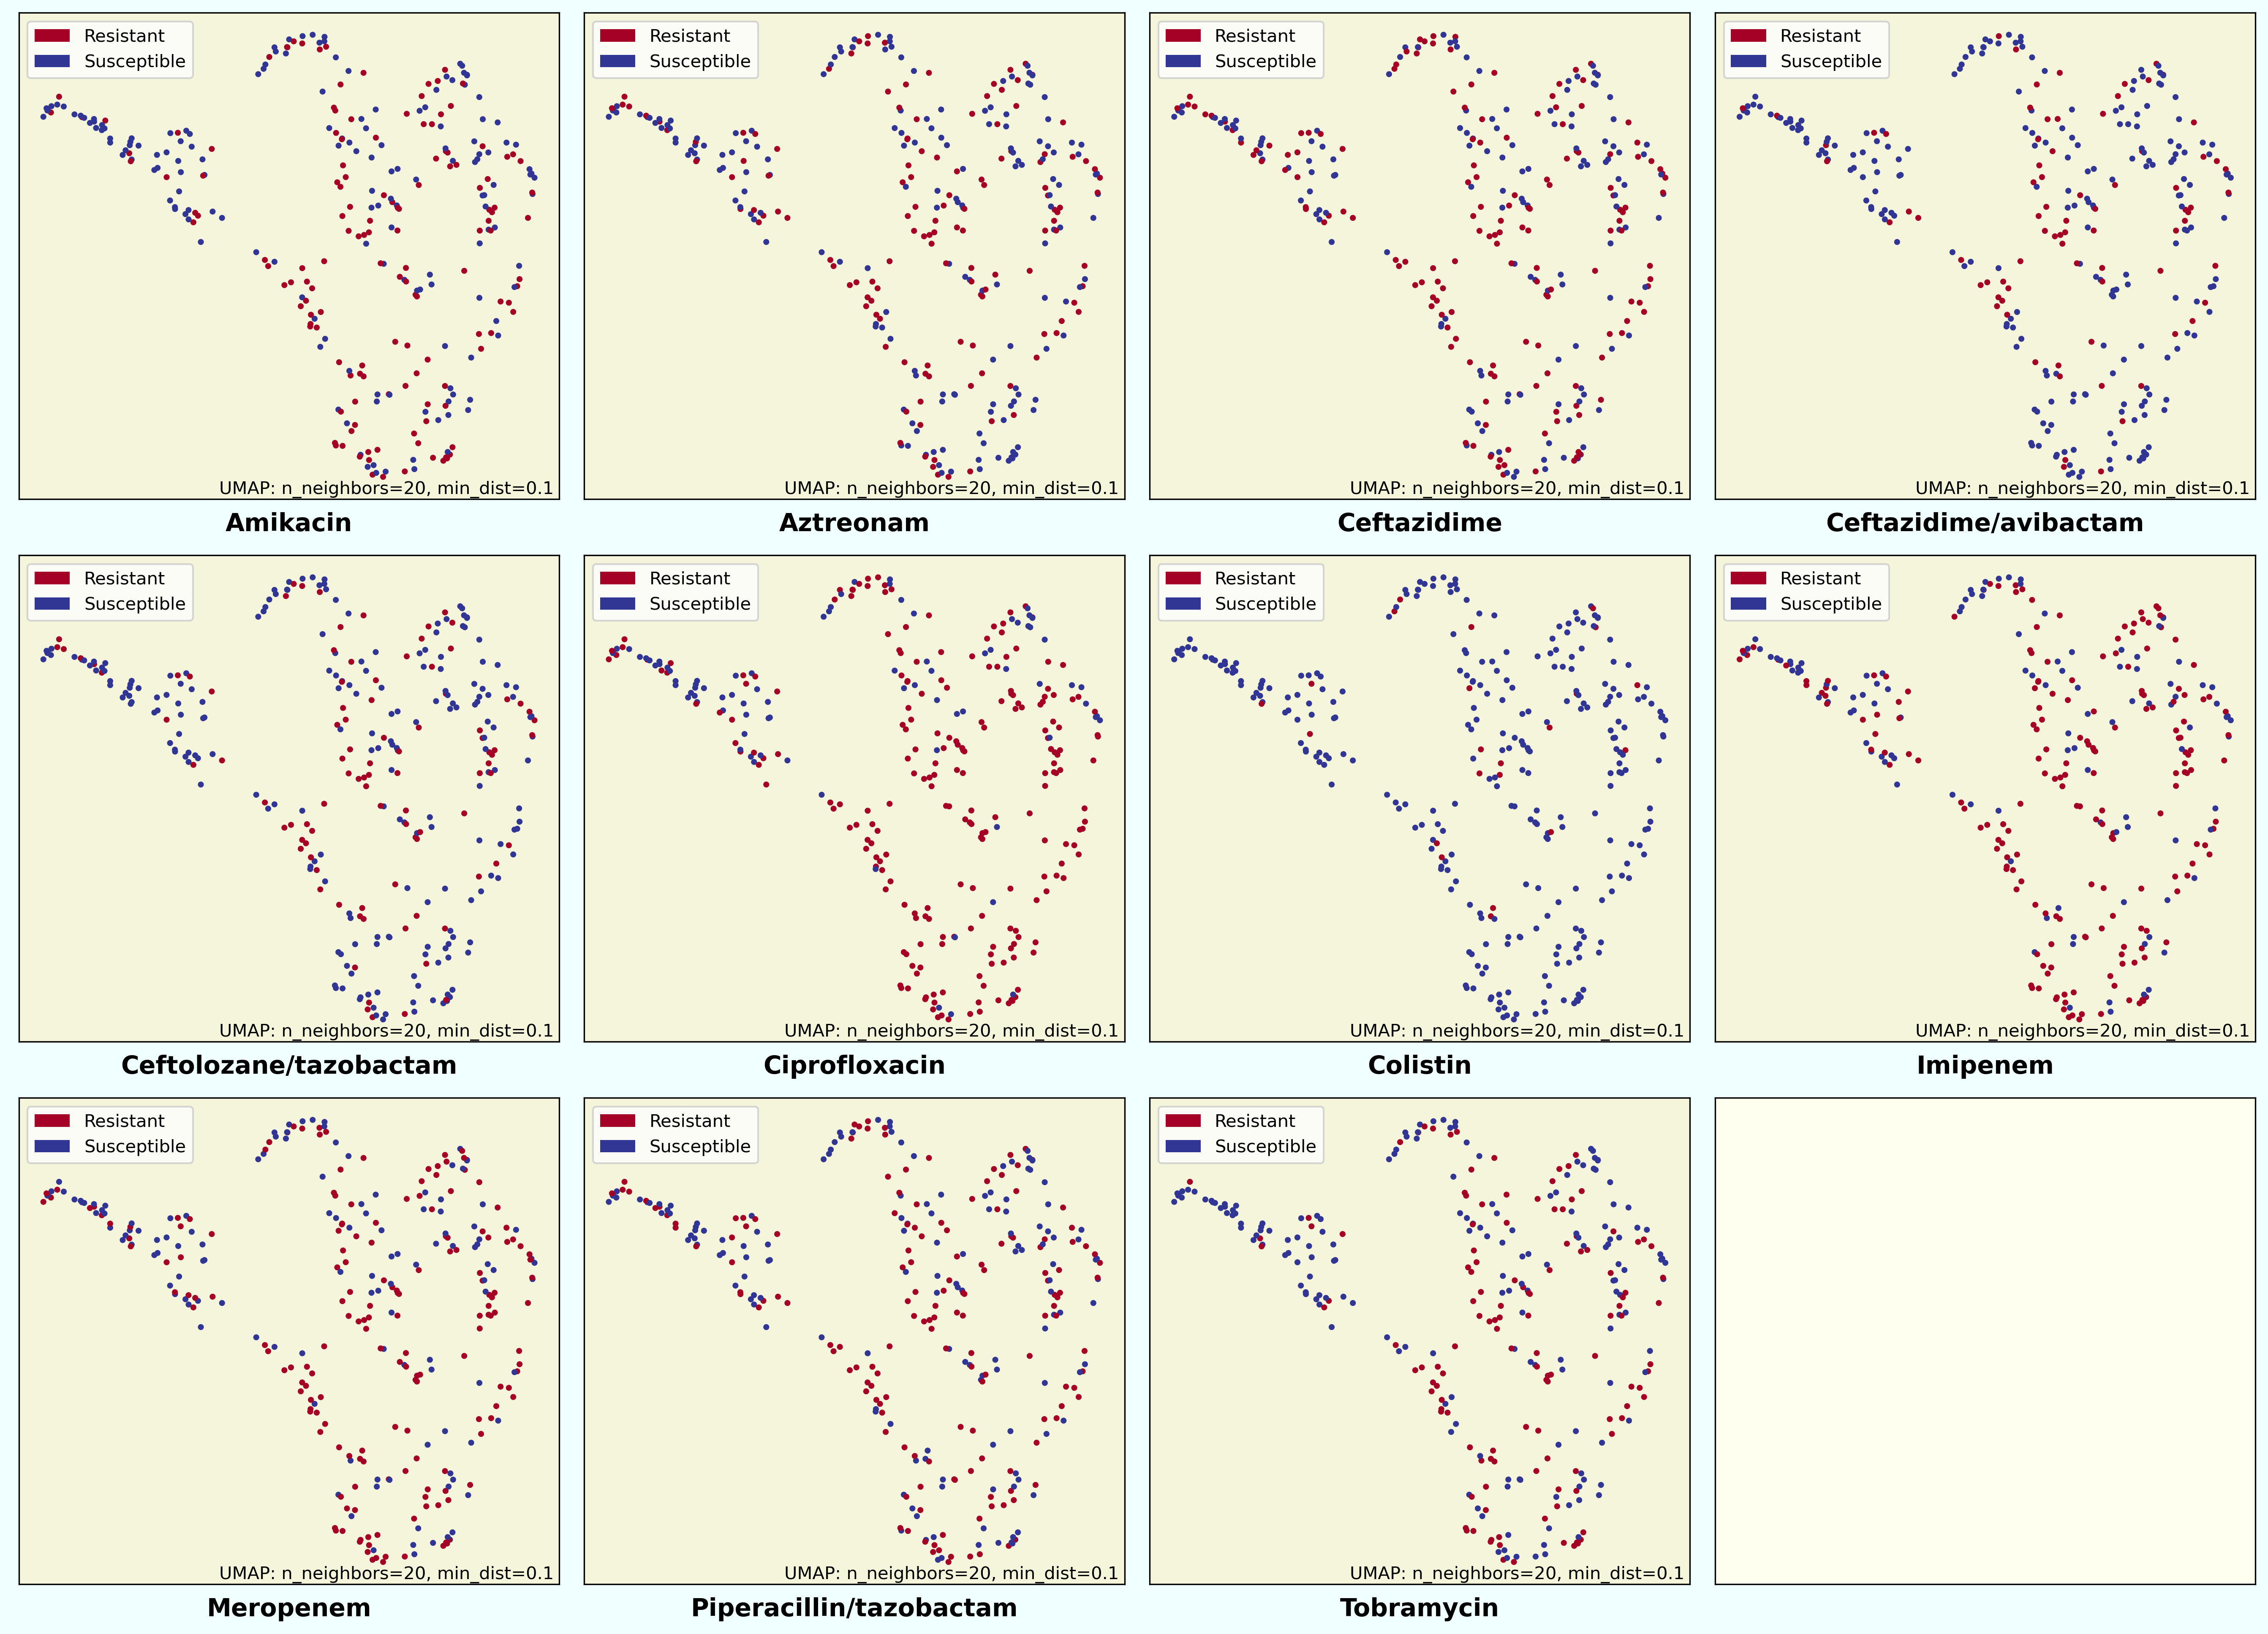

In [7]:
counter = 0
nrows = 3
ncols = 4

fig, ax = umap.plot.plt.subplots(nrows, ncols, figsize=(18,13), dpi=300)

for row_idx in range(nrows):
    for col_idx in range(ncols):
        tmp_ax = ax[row_idx, col_idx]
        if counter == len(alfred_antimicrobials):
            tmp_ax.set_facecolor('ivory')
            tmp_ax.set(xlabel=None, ylabel=None)
            tmp_ax.set_xticks([])
            tmp_ax.set_yticks([])
            break
        else:
            antimicrobial = sorted(alfred_antimicrobials)[counter]
            label = pae_alfred[antimicrobial].values
            to_ast_label  = lambda t: 'Susceptible' if t == 0 else "Resistant"
            to_ast_func = np.vectorize(to_ast_label)
            label = to_ast_func(label)
            umap.plot.points(mapper, 
                             labels=label,
                             color_key_cmap='RdYlBu',
                             background='beige',
                             ax=tmp_ax)
            rect1 = patches.Rectangle((4.7, 7.3), 7, 2.5, linewidth=1,  edgecolor='orangered', facecolor='none')
            # rect1 = patches.Rectangle((-5.54, 0.1), 3, 4.8, linewidth=1,  edgecolor='yellow', facecolor='none')
            # rect2 = patches.Rectangle((11.5, 3), 3, 6, linewidth=1,  edgecolor='orange', facecolor='none')
            # tmp_ax.add_patch(rect1)
            # tmp_ax.add_patch(rect2)
            tmp_ax.set_xlabel(antimicrobials[antimicrobial], 
                              fontweight='bold', 
                              fontsize=14)
            # tmp_ax.plot(X_sample[:40], 
            #             Y_sample[:40], 
            #             'gs')
            # tmp_ax.plot(umap_alfred_test_values[:, 0], 
            #             umap_alfred_test_values[:, 1], 
            #             'gs')

        counter += 1

fig.patch.set_facecolor('azure')
plt.tight_layout()

# Clustering algorithm

Elbow value: 5


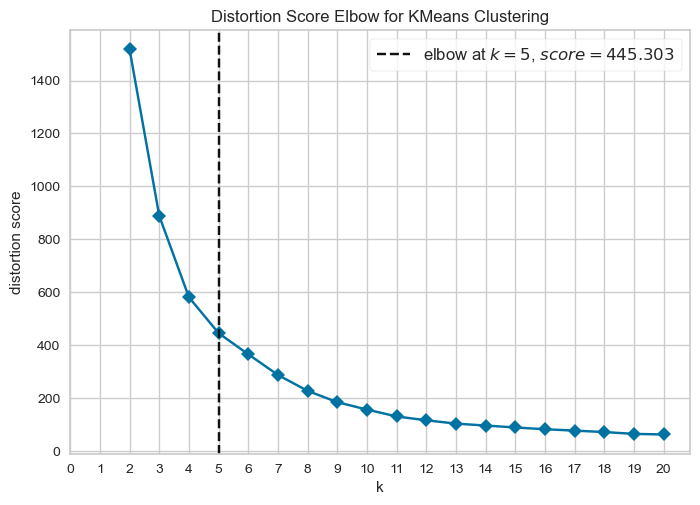

In [8]:
# Determine optimal number of clusters by elbow method
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=222)

visualizer = KElbowVisualizer(model, k=20, timings=False, metric='distortion')
visualizer.fit(umap_values)
print(f"Elbow value: {visualizer.elbow_value_}")
visualizer.ax.set_xticks(np.arange(0, 21, 1))
visualizer.ax.set_xlabel("Number of clusters")
visualizer.show()

plt.show()

In [9]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_, 
                random_state=222).fit(umap_values)

test_labels = kmeans.predict(umap_alfred_test_values)

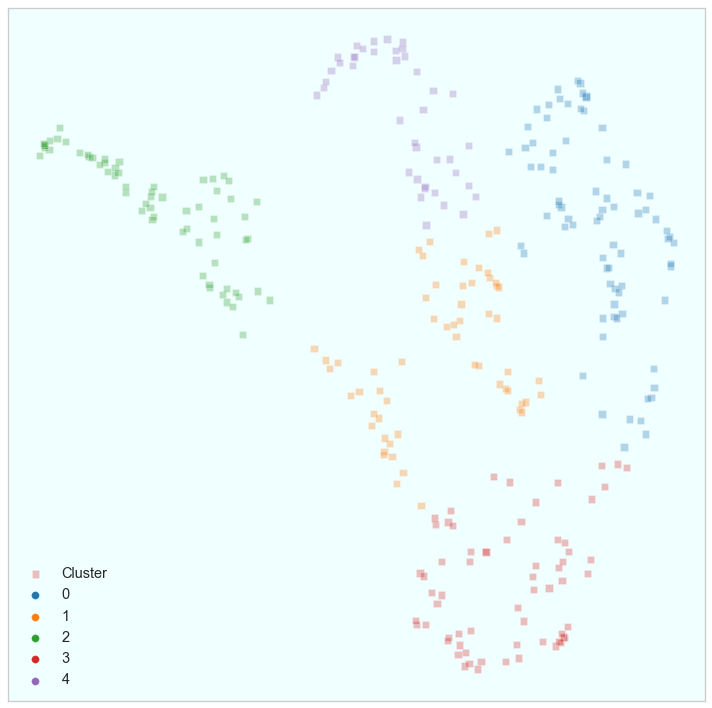

In [10]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=kmeans.labels_, 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [11]:
kmeans_train_ids = pd.DataFrame({"id": alfred_train_ids, 
                                 'cluster': kmeans.labels_})
kmeans_test_ids = pd.DataFrame({"id": alfred_test_ids, 
                                'cluster': test_labels})
kmean_cluster_df = pd.concat([kmeans_train_ids, kmeans_test_ids], 
                             axis=0, ignore_index=True)
ohe_cluster = pd.get_dummies(kmean_cluster_df, columns=['cluster'])


In [24]:
# Extract training data for each cluster
for i in kmeans_train_ids['cluster'].value_counts().index:
    tmp_df = kmeans_train_ids.copy()[kmeans_train_ids['cluster'] == i]
    tmp_df['id'].to_csv(f"outputs/training_id_cluster_{i}.txt", header=False, index=False)



In [12]:
# kmean_cluster_df.to_csv("~/Downloads/kmeans_cluster_090223.csv", index=False)

In [14]:
previous_kmean_cluster_df = pd.read_csv("~/Downloads/cluster_info_kmeans_previous_run.csv")

In [23]:
cluster_dict = {0: 0,
                1: 2,
                2: 1,
                3: 3,
                4: 4}

merged_kmeans_train = kmeans_train_ids.merge(previous_kmean_cluster_df,
                                             on='id',
                                             how='inner',
                                             suffixes=('_current', '_former'))

merged_kmeans_train['mapped_cluster_former'] = merged_kmeans_train.apply(lambda row: cluster_dict[row['cluster_former']], axis=1)

In [26]:
sum(merged_kmeans_train['cluster_current'] == merged_kmeans_train['mapped_cluster_former'])

155

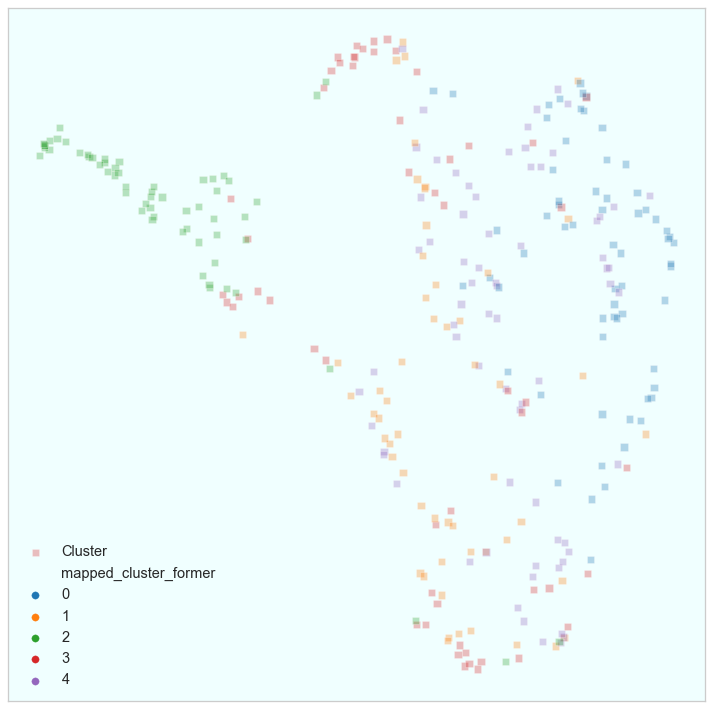

In [28]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=merged_kmeans_train['mapped_cluster_former'], 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

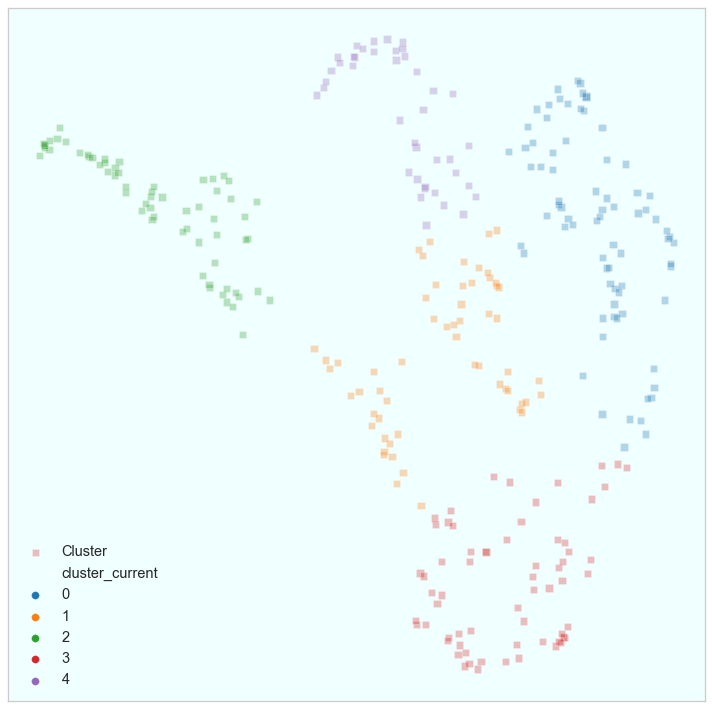

In [29]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=75)

ax = sns.scatterplot(umap_values[:,0], 
                     umap_values[:,1], 
                     marker='s',
                     hue=merged_kmeans_train['cluster_current'], 
                     palette='tab10',
                     label='Cluster',
                     alpha=0.3)

ax.set_facecolor('azure')
ax.grid(False)
ax.legend(fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.show()